**Objectif** : on va dans un premier temps chercher à prédire la consommation électrique uniquement à partir des données historiques. Pour cela on va tronquer la fin de la série, effectuer une prédiction puis vérifier avec les données réelles. Dans un deuxième temps on va utiliser les données météorologiques afin d'améliorer la prédiction.

# 1 - Import des bibliothèques

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
chemin_scripts = os.path.abspath(os.path.join(os.getcwd(), '..', 'scripts'))
sys.path.append(chemin_scripts)

from fonctions_conso import importation, clean, traitement_valeurs_manquantes

# 2 - Récupération des données

In [5]:
url = "https://odre.opendatasoft.com/api/explore/v2.1/catalog/datasets/eco2mix-metropoles-tr/exports/csv?lang=fr&refine=libelle_metropole%3A%22M%C3%A9tropole%20du%20Grand%20Paris%22&facet=facet(name%3D%22libelle_metropole%22%2C%20disjunctive%3Dtrue)&timezone=Europe%2FParis&use_labels=true&delimiter=%3B"
df = traitement_valeurs_manquantes(clean(importation(url)))[['conso_final']]

In [21]:
df.head(2)

,conso_final
date_heure,
2020-01-01 01:00:00,5090.0
2020-01-01 01:15:00,5018.0


# 3 - Test de stationnarité

Tester la stationnarité d'une série temporelle est crucial pour l'analyse et la modélisation des données temporelles. La stationnarité garantit la stabilité des propriétés statistiques de la série au fil du temps, permettant d'appliquer des modèles appropriés et d'obtenir des résultats valides et des prévisions fiables.

On rappelle qu'une série temporelle à valeurs réelles en temps discret $X_1,...,X_t$ est dite faiblement stationnaire si :

$$
\begin{cases}
\mathbb{E}[X_i] = \mu \hspace{1cm} \forall i \\
Var(X_i) = \sigma ^2 \hspace{1cm} \forall i \\
Cov(X_i, X_{i-k}) = \rho _k \hspace{1cm} \forall i, \forall k
\end{cases}
$$

On va commencer par tester la stationnarité de la série des consommations d'électricité de la métropole parisienne afin de choisir par la suite le bon modèle de prédiction. Pour cela, on effectue le test de racine unitaire de Dickey-Füller augmenté (test ADF) dont les hypothèses sont les suivantes :

$$
\begin{cases}
H_0 : \text{présence de racine unitaire} \Leftrightarrow \text{série non stationnaire} \\
H_1 : \text{absence de racine unitaire} \Leftrightarrow \text{série stationnaire}
\end{cases}
$$

Les valeurs critiques du test ADF diffèrent selon l'hypothèse choisie pour le processus générateur de données (DGP) de la série temporelle :

- **DGP 1** (sans partie déterministe, option `regression='n'` dans adfuller) : 
$$ X_t = \phi X_{t-1} + \epsilon_t $$  
Valeur critique au seuil 5% pour le rejet de $H_0$ : -1,95

- **DGP 2** (avec constante, option `regression='c'` dans adfuller) :  
$$ X_t = a + \phi X_{t-1} + \epsilon_t $$  
Valeur critique au seuil 5% pour le rejet de $H_0$ : -2,89

- **DGP 3** (avec constante et trend, option `regression='ct'` dans adfuller) : 
$$ X_t = a + b t + \phi X_{t-1} + \epsilon_t $$  
Valeur critique au seuil 5% pour le rejet de $H_0$ : -3,45

Lorsque la valeur du test ADF est inférieure au seuil critique associé à l'hypothèse choisie, on rejette $H_0$, c’est-à-dire que la série est stationnaire.


In [36]:
def adf_table(series, alpha=0.05):
    results = []
    dgp = {'n' : 'DGP1', 'c' : 'DGP2', 'ct' : 'DGP3'}

    for reg, label in dgp.items():
        adf_result = adfuller(series, regression=reg)

        adf_stat = adf_result[0]
        crit_value = adf_result[4]['5%']

        conclusion = "Stationnaire" if adf_stat < crit_value else "Non stationnaire"

        results.append({
            "DGP": label,
            "ADF statistic": adf_stat,
            "Valeur critique (5%)": crit_value,
            "Conclusion": conclusion
        })

    return pd.DataFrame(results)

In [37]:
df_adf = adf_table(df)

In [38]:
df_adf

,DGP,ADF statistic,Valeur critique (5%),Conclusion
0,DGP1,-1.273610,-1.941001,Non stationnaire
1,DGP2,-5.760323,-2.861554,Stationnaire
2,DGP3,-5.762672,-3.410511,Stationnaire


**Conclusion** : la série est stationnaire autour d'une constante $\neq$ 0. Elle est de type DGP3 avec a et b significatifs. On n'a donc pas besoin de la stationnariser et il va être plus facile d'effectuer des prédictions.

# 4 - Dé-saisonnalisation

**Rappels** :

Il existe plusieurs modèles classiques pour la modélisation des séries temporelles :
- AR (AutoRegressive) : la valeur actuelle dépend de ses valeurs passées, utilisé lorsque la série présente de l'autocorrélation
- MA (MovingAverage) : la valeur actuelle dépend des erreurs passées, utilisé lorsque les chocs passés influencent les valeurs futures
- ARMA : AR + MA utilisé lorsque les séries sont stationnaires
- ARIMA : extension d'ARMA aux séries non stationnaires basé sur un nombre de différenciations qui rend la série stationnaire
- SARIMA : ARIMA + saisonnalité
- GARCH : modélise la volatilité passée combinée à l'effet des chocs passés

Chaque modèle dépend d'un ou plusieurs paramètres appelés *ordre* à déterminer à partir des valeurs de la série.

La série étant stationnaire, on va vraisemblablement l'estimer par un modèle ARMA. Mais la série des consommations électriques présente de fortes saisonnalités journalière, hebdomadaire et mensuelle ce qui risque de biaiser fortement les coefficients de l'ARMA. Pour cela on va devoir au préalable désaisonnaliser la série. On ne va pas pouvoir utiliser un modèle SARIMA car le modèle SARIMA ne peut gérer qu'une seule saisonnalité.

On va utiliser STL pour gérer la saisonnalité

In [ ]:
from statsmodels.tsa.seasonal import STL

# --- 1. Extraire la saison journalière (96 mesures / jour) ---
stl_daily = STL(df, period=96, robust=True)
res_daily = stl_daily.fit()
deseason_daily = df['conso_final'] - res_daily.seasonal

# --- 2. Extraire la saison hebdomadaire sur les résidus ---
stl_weekly = STL(deseason_daily, period=672, robust=True)
res_weekly = stl_weekly.fit()
deseason_weekly = deseason_daily - res_weekly.seasonal

# --- 3. Extraire la saison mensuelle sur les résidus ---
stl_monthly = STL(deseason_weekly, period=2880, robust=True)
res_monthly = stl_monthly.fit()
residuals = deseason_weekly - res_monthly.seasonal

# --- 4. Visualiser ---
plt.figure(figsize=(15,10))
plt.subplot(4,1,1)
plt.plot(df, label='Originale')
plt.legend()

plt.subplot(4,1,2)
plt.plot(res_daily.seasonal, label='Saison journalière')
plt.legend()

plt.subplot(4,1,3)
plt.plot(res_weekly.seasonal, label='Saison hebdomadaire')
plt.legend()

plt.subplot(4,1,4)
plt.plot(res_monthly.seasonal, label='Saison mensuelle + résidus')
plt.legend()

plt.tight_layout()
plt.show()

# 5 - Modèle ARMA : choix des paramètres

Un modèle ARMA est défini par 2 ordres : 
- p : l'ordre de l'AR spécifie le nombre de termes autorégressifs à inclure dans le modèle. Il indique combien de valeurs passées sont utilisées pour prédire la valeur actuelle.
- q : l'ordre du MA spécifie le nombre de termes de la moyenne mobile à inclure dans le modèle. Il indique combien de résidus passés sont utilisés pour prédire l'observation actuelle.

On va devoir déterminer ces ordres. Pour cela on a plusieurs méthodes :
- visuellement en regardant l'ACF et le PACF
- en calculant les critères d'information AIC et BIC

## 5.1 - ACF et PACF

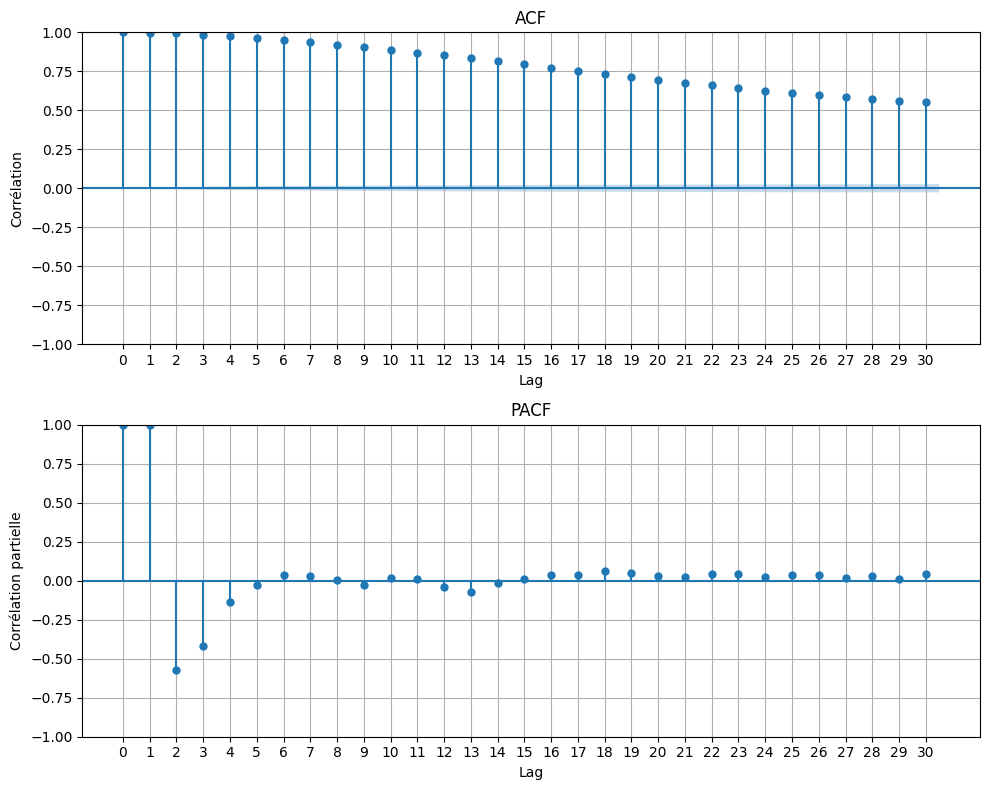

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Créer les subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Tracer l'ACF
plot_acf(df['conso_final'], lags=30, zero=True, ax=ax1)
ax1.set_title('ACF')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Corrélation')
ax1.grid(True)

# Ajuster les graduations sur l'axe x pour l'ACF
ax1.set_xticks(np.arange(0, 31, 1))

# Tracer le PACF
plot_pacf(df['conso_final'], lags=30, zero=True, ax=ax2)
ax2.set_title('PACF')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Corrélation partielle')
ax2.grid(True)

# Ajuster les graduations sur l'axe x pour le PACF
ax2.set_xticks(np.arange(0, 31, 1))

# Ajuster les subplots
plt.tight_layout()

# Afficher le graphique
plt.show()

**Interprétation** :
- pas de coupure nette de l'ACF, donc il ne semble pas y avoir de partie MA => q=0
- coupure nette de la PACF après le lag 2, semble suggérer un AR pur de lag 2 => p=2
  
L'analyse de l'ACF et de la PACF semblerait nous suggérer d'utiliser un AR(2), à reconfirmer avec les critères d'information. Il faut aussi tenir compte du fait que l'échantillon considéré est assez conséquent, plus de 200 000 observations ce qui peut modifier les seuils standards.

### 4.1.2 - Critères d'information

**Attention** : la cellule suivante prend plusieurs minutes à compiler 40min, pas tester sur toutes les données ex choisir 1 an ?

In [26]:
from statsmodels.tsa.arima.model import ARIMA
import itertools
import numpy as np

#on définit la fréquence des données pour éviter les warning
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df = df.asfreq("15min")

#intervalles de p et q testés
p = range(0, 5)
q = range(0, 5)

best_bic = np.inf
best_order = None

for order in itertools.product(p, q):
    try:
        model = ARIMA(df['conso_final'], order=(order[0], 0, order[1]))
        result = model.fit()
        
        if result.bic < best_bic:
            best_bic = result.bic
            best_order = order
            
    except:
        continue

print("Meilleur ARMA(p,q) selon le critère BIC :", best_order)
print("BIC :", best_bic)

C:\Users\angel\OneDrive\Documents\ENSAE\2A\S1\python\projet_pythonds\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\angel\OneDrive\Documents\ENSAE\2A\S1\python\projet_pythonds\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\angel\OneDrive\Documents\ENSAE\2A\S1\python\projet_pythonds\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\angel\OneDrive\Documents\ENSAE\2A\S1\python\projet_pythonds\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Meilleur ARMA(p,q) selon le critère BIC : (3, 3)
BIC : 2247866.875957845


**Conclusion** : avec le critère BIC et avec le critère AIC on trouve un ARMA(3,3)

Il semblerait qu'il existe finalement une légère composante MA. L'AR capture la dynamique de fond et le MA capture une corrélation de court terme dans les innovations, cette correction est suffisamment utile pour survivre à la pénalité BIC.

In [19]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            conso_final   No. Observations:               209948
Model:                 ARIMA(3, 0, 3)   Log Likelihood            -1123884.420
Date:                Sat, 27 Dec 2025   AIC                        2247784.839
Time:                        19:45:14   BIC                        2247866.876
Sample:                    01-01-2020   HQIC                       2247808.933
                         - 12-26-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3973.7530     21.942    181.101      0.000    3930.747    4016.759
ar.L1          0.9524      0.011     86.763      0.000       0.931       0.974
ar.L2          0.8326      0.020     41.757      0.000       0.794       0.872
ar.L3         -0.7913      0.009    -86.178      0.000      -0.809      -0.773
ma.L1          0.3114      0.011     28.504      0.000       0.290       0.333
ma.L2         -0.3323      0.007    -49.929      0.000      -0.345      -0.319
ma.L3          0.1763      0.003     55.091      0.000       0.170       0.183
sigma2      2609.9475      2.000   1305.114      0.000    2606.028    2613.867
===================================================================================
Ljung-Box (L1) (Q):                   0.54   Jarque-Bera (JB):          23850486.02
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        55.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
tous les coeff MA sont bien significatifs
test de LB : OK

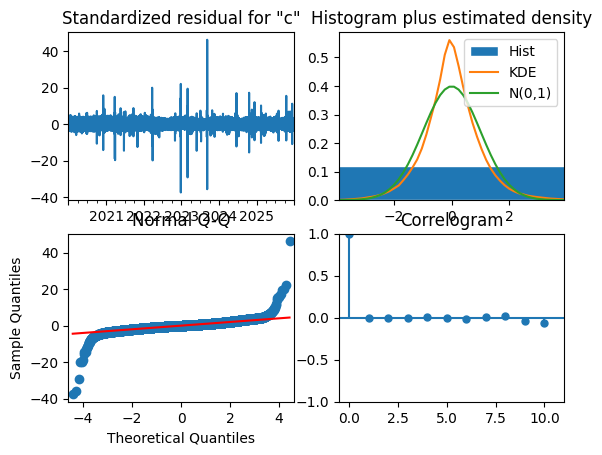

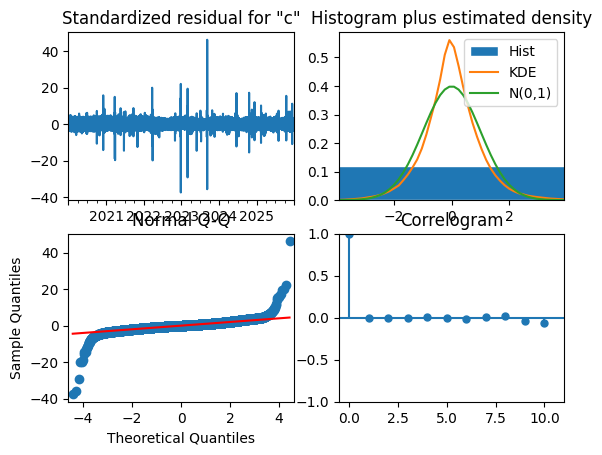

In [20]:
result.plot_diagnostics()

In [ ]:
ACF des résidus plate => bon modèle choisi